<h1>GoJek App Reviewer</h1>
<b>Yeremia Maydinata Narana || 5026221068</b>

In this project, I will find find the most common complaints in Gojek Apps :)

Gunakan CUDA jika device memilikinya

In [1]:
!pip install tensorflow -q
!pip install tensorflow_hub -q
!pip install torch
!pip install xgboost -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch 

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


# #1 Scrapping Data #
Scrapping data from Google Play Store using <b>google-play-scraper</b> library.

In [6]:
!pip install google_play_scraper -q
!pip install textblob -q
!pip install seaborn -q

In [7]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [8]:
#Android App Gojek from Google Play at
#https://play.google.com/store/apps/details?id=com.gojek.app
#The apps ID found in the link after id=com.gojek.app

from google_play_scraper import app, Sort, reviews_all

gojek_reviews = reviews_all(
    'com.gojek.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [9]:
df_gjkrev = pd.DataFrame(np.array(gojek_reviews),columns=['content'])
df_gjkrev = df_gjkrev.join(pd.DataFrame(df_gjkrev.pop('content').tolist()))

In [10]:
df_gjkrev
df_gjkrev.info()
df_gjkrev['score'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226472 entries, 0 to 226471
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              226472 non-null  object        
 1   userName              226472 non-null  object        
 2   userImage             226472 non-null  object        
 3   content               226437 non-null  object        
 4   score                 226472 non-null  int64         
 5   thumbsUpCount         226472 non-null  int64         
 6   reviewCreatedVersion  193791 non-null  object        
 7   at                    226472 non-null  datetime64[ns]
 8   replyContent          35192 non-null   object        
 9   repliedAt             35192 non-null   datetime64[ns]
 10  appVersion            193791 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 19.0+ MB


score
5    123361
1     51218
4     21979
3     15523
2     14391
Name: count, dtype: int64

In [11]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_gjkrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

content  score  \
0       VOCHER BANDARANYA SERING BANGET UDAH BISA KLAI...      1   
1                                                    good      4   
2       susah banget booking ,gak kayak ijo sebelah, m...      2   
3       some time good, other times bad. overall so so...      3   
4       kodee promonya makin sinii makin menurun, dari...      2   
...                                                   ...    ...   
226467                                      Love this app      5   
226468                              Akhirnya keluar juga!      5   
226469                                            Finally      5   
226470                                            Helpful      4   
226471                                     Usefull banget      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0               5.12.1 2025-10-13 08:39:46   
1                   0               5.34.2 2025-10-13 08:02:55   
2                   0               5.34.2 2025-10-13 06:20:15   
3                   0               5.34.2 2025-10-13 05:24:35   
4                   0                 None 2025-10-13 00:50:05   
...               ...                  ...                 ...   
226467              0                1.0.1 2014-12-31 04:11:06   
226468              0                1.0.1 2014-12-24 22:20:26   
226469              0                1.0.1 2014-12-23 12:04:16   
226470              0                 None 2014-12-20 23:41:52   
226471              1                 None 2014-12-19 22:00:21   

                                             replyContent           repliedAt  
0       Hai Kak @Proto twelve, mohon maaf atas ketidak... 2025-10-13 10:06:04  
1                                                    None                 NaT  
2       Mohon maaf atas kendala yang dialami, Kak Mari... 2025-10-13 07:51:06  
3                                                    None                 NaT  
4                                                    None                 NaT  
...                                                   ...                 ...  
226467                                               None                 NaT  
226468                                               None                 NaT  
226469                                               None                 NaT  
226470                                               None                 NaT  
226471                                               None                 NaT  

[226472 rows x 7 columns]

# #2 Preprocessing Data #

 ## Sentiment before Preprocessing ##

In [12]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_gjkrev['sentiment_rating'] = df_gjkrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [13]:
from textblob import TextBlob
df_gjkrev['sentiment_polarity'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_gjkrev['sentiment_subjective'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

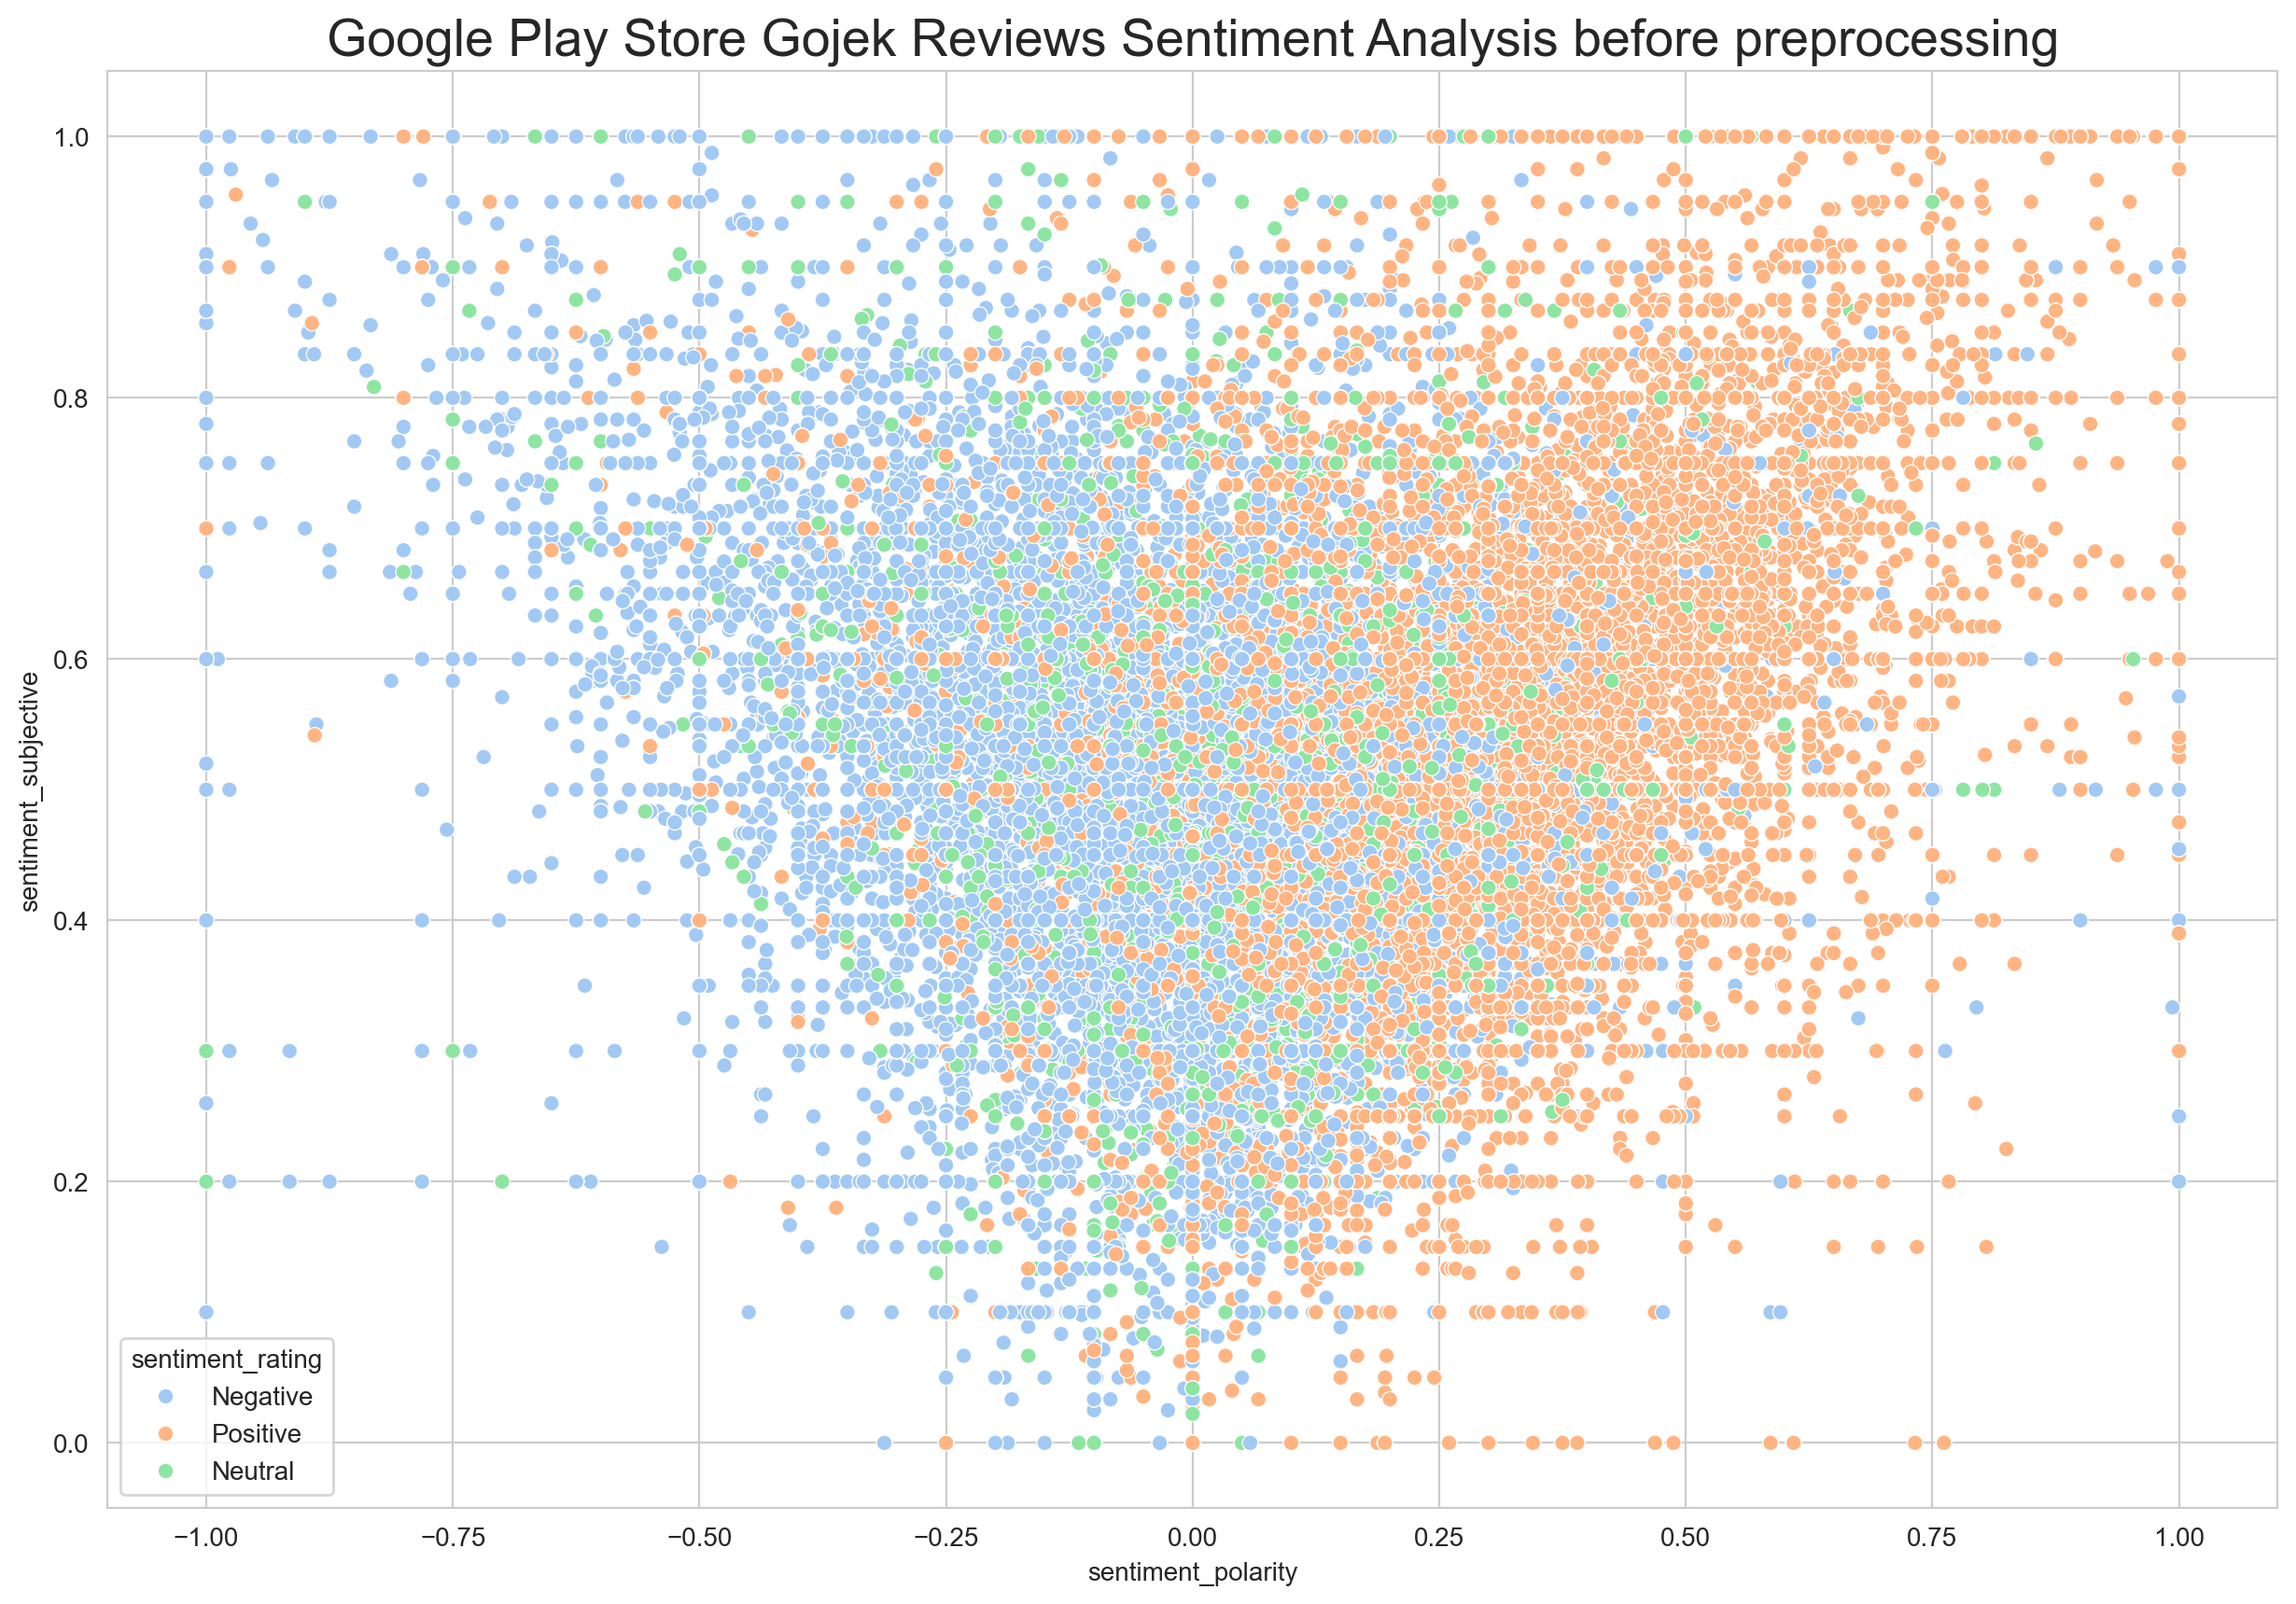

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis before preprocessing", fontsize=20)
plt.show()

In [15]:
!pip install emoji

In [16]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

## a. Lowercasing ##

In [17]:
# Lower casing
# Change the reviews type to string
df_gjkrev['content'] = df_gjkrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

Promo-promo di akun saya tiba-tiba diblokir tanpa ada alasan yang jelas. Saya tidak merasa melakukan kecurangan apapun selama menggunakan aplikasi gojek ini yang membuat promo di akun saya diblokir. Saya sudah mecoba membuat laporan tetapi customer servicenya SANGAT sulit untuk dihubungi.
good
Mantap


In [18]:
#Lowercase all reviews to see the difference
df_gjkrev['content']= df_gjkrev['content'].apply(lambda x: x.lower())
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

promo-promo di akun saya tiba-tiba diblokir tanpa ada alasan yang jelas. saya tidak merasa melakukan kecurangan apapun selama menggunakan aplikasi gojek ini yang membuat promo di akun saya diblokir. saya sudah mecoba membuat laporan tetapi customer servicenya sangat sulit untuk dihubungi.
good
mantap


In [19]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  \
0                                                            vocher bandaranya sering banget udah bisa klaim tapi gak muncul!   
1                                                                                                                        good   
2                       susah banget booking ,gak kayak ijo sebelah, muter2 doang lama, udah dapet driver banyakan gak gerak.   
3       some time good, other times bad. overall so so lah.. you guys already marked the market and it looks good on the map.   
4                              kodee promonya makin sinii makin menurun, dari 100 ke 70 skrg auto 50% doangg, kit atii tauuuu   
...                                                                                                                       ...   
226467                                                                                                          love this app   
226468                                                                                                  akhirnya keluar juga!   
226469                                                                                                                finally   
226470                                                                                                                helpful   
226471                                                                                                         usefull banget   

        score  sentiment_polarity  sentiment_subjective  
0           1              0.0000              0.000000  
1           4              0.7000              0.600000  
2           2              0.0000              0.000000  
3           3              0.1125              0.473611  
4           2              0.0000              0.000000  
...       ...                 ...                   ...  
226467      5              0.5000              0.600000  
226468      5              0.0000              0.000000  
226469      5              0.0000              1.000000  
226470      4              0.0000              0.000000  
226471      5              0.0000              0.000000  

[226472 rows x 4 columns]

## b. Stopwords Removal ##

In [20]:
!pip install Sastrawi

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

df_gjkrev['wordCount'] = [len(review.split()) for review in df_gjkrev['content']]
df_gjkrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_gjkrev['content']]
df_gjkrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_gjkrev['content']]

In [23]:
# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_gjkrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

In [24]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

content  \
0                                                            vocher bandaranya sering banget udah bisa klaim tapi gak muncul!   
1                                                                                                                        good   
2                       susah banget booking ,gak kayak ijo sebelah, muter2 doang lama, udah dapet driver banyakan gak gerak.   
3       some time good, other times bad. overall so so lah.. you guys already marked the market and it looks good on the map.   
4                              kodee promonya makin sinii makin menurun, dari 100 ke 70 skrg auto 50% doangg, kit atii tauuuu   
...                                                                                                                       ...   
226467                                                                                                          love this app   
226468                                                                                                  akhirnya keluar juga!   
226469                                                                                                                finally   
226470                                                                                                                helpful   
226471                                                                                                         usefull banget   

        score  sentiment_polarity  sentiment_subjective  wordCount  \
0           1              0.0000              0.000000         10   
1           4              0.7000              0.600000          1   
2           2              0.0000              0.000000         16   
3           3              0.1125              0.473611         23   
4           2              0.0000              0.000000         17   
...       ...                 ...                   ...        ...   
226467      5              0.5000              0.600000          3   
226468      5              0.0000              0.000000          3   
226469      5              0.0000              1.000000          1   
226470      4              0.0000              0.000000          1   
226471      5              0.0000              0.000000          2   

        uppercaseCharCount  specialCharCount  
0                        0                 1  
1                        0                 0  
2                        0                 4  
3                        0                 5  
4                        0                 3  
...                    ...               ...  
226467                   0                 0  
226468                   0                 1  
226469                   0                 0  
226470                   0                 0  
226471                   0                 0  

[226472 rows x 7 columns]

In [25]:
# Indonesian Stopword Removal using Sastrawi
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

sastrawi_stopwords = factory.get_stop_words()
print(f"There's total {len(sastrawi_stopwords)} Indonesian stopwords removed.")

There's total 126 Indonesian stopwords removed.


In [26]:
# English Stopword Removal using NLTK
# Get English stopwords
import nltk
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

# To get the number of English stopwords, use the len() function:
print(f"There's total {len(english_stopwords)} English stopwords removed.")


There's total 198 English stopwords removed.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Apply stopword removal to the 'content' column
df_gjkrev['content'] = df_gjkrev['content'].apply(lambda x: stopword_remover.remove(x))

 ## c. Cleaning Text ##
(Include Stemming and Lemmatize)

In [28]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Create stemmer and lemmatizer objects
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # menghapus special character
  text = re.sub(r'[^\w\s]', ' ', text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  text = re.sub(r"\b[a-zA-Z]\b", "", text)
  # stemming
  text = stemmer.stem(text)
  # lemmatize
  words = text.split()
  lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
  text = ' '.join(lemmatized_words)
  return text

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HiliCe\AppData\Local\Temp\ipykernel_18964\992346851.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [30]:
df_gjkrev.loc[:, 'clean'] = df_gjkrev['content'].apply(cleaning_text)

# Display the first few rows of the DataFrame with the cleaned reviews
print("DataFrame with cleaned reviews (first 5 rows):")
display(df_gjkrev[['content', 'clean']].head())

DataFrame with cleaned reviews (first 5 rows):


content  \
0                                                                 vocher bandaranya sering banget udah klaim gak muncul!   
1                                                                                                                   good   
2                  susah banget booking ,gak kayak ijo sebelah, muter2 doang lama, udah dapet driver banyakan gak gerak.   
3  some time good, other times bad. overall so so lah.. you guys already marked the market and it looks good on the map.   
4                                 kodee promonya makin sinii makin menurun, 100 70 skrg auto 50% doangg, kit atii tauuuu   

                                                                                                         clean  
0                                                           vocher bandara sering banget udah klaim gak muncul  
1                                                                                                         good  
2                    susah banget book gak kayak ijo belah muter doang lama udah dapet driver banyak gak gerak  
3  some time good other time bad overall so so lah you guy already mark the market and it look good on the map  
4                                        kodee promonya makin sini makin turun skrg auto doangg kit ati tauuuu

# #3 Hasil Review #

## a. Frequency Words ##

Word  Frequency
0      the      35316
1     good      29589
2       to      28189
3   driver      26821
4    gojek      24866
..     ...        ...
95      sy       3000
96   harga       2928
97      or       2915
98    from       2913
99     get       2900

[100 rows x 2 columns]

C:\Users\HiliCe\AppData\Local\Temp\ipykernel_18964\856327870.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


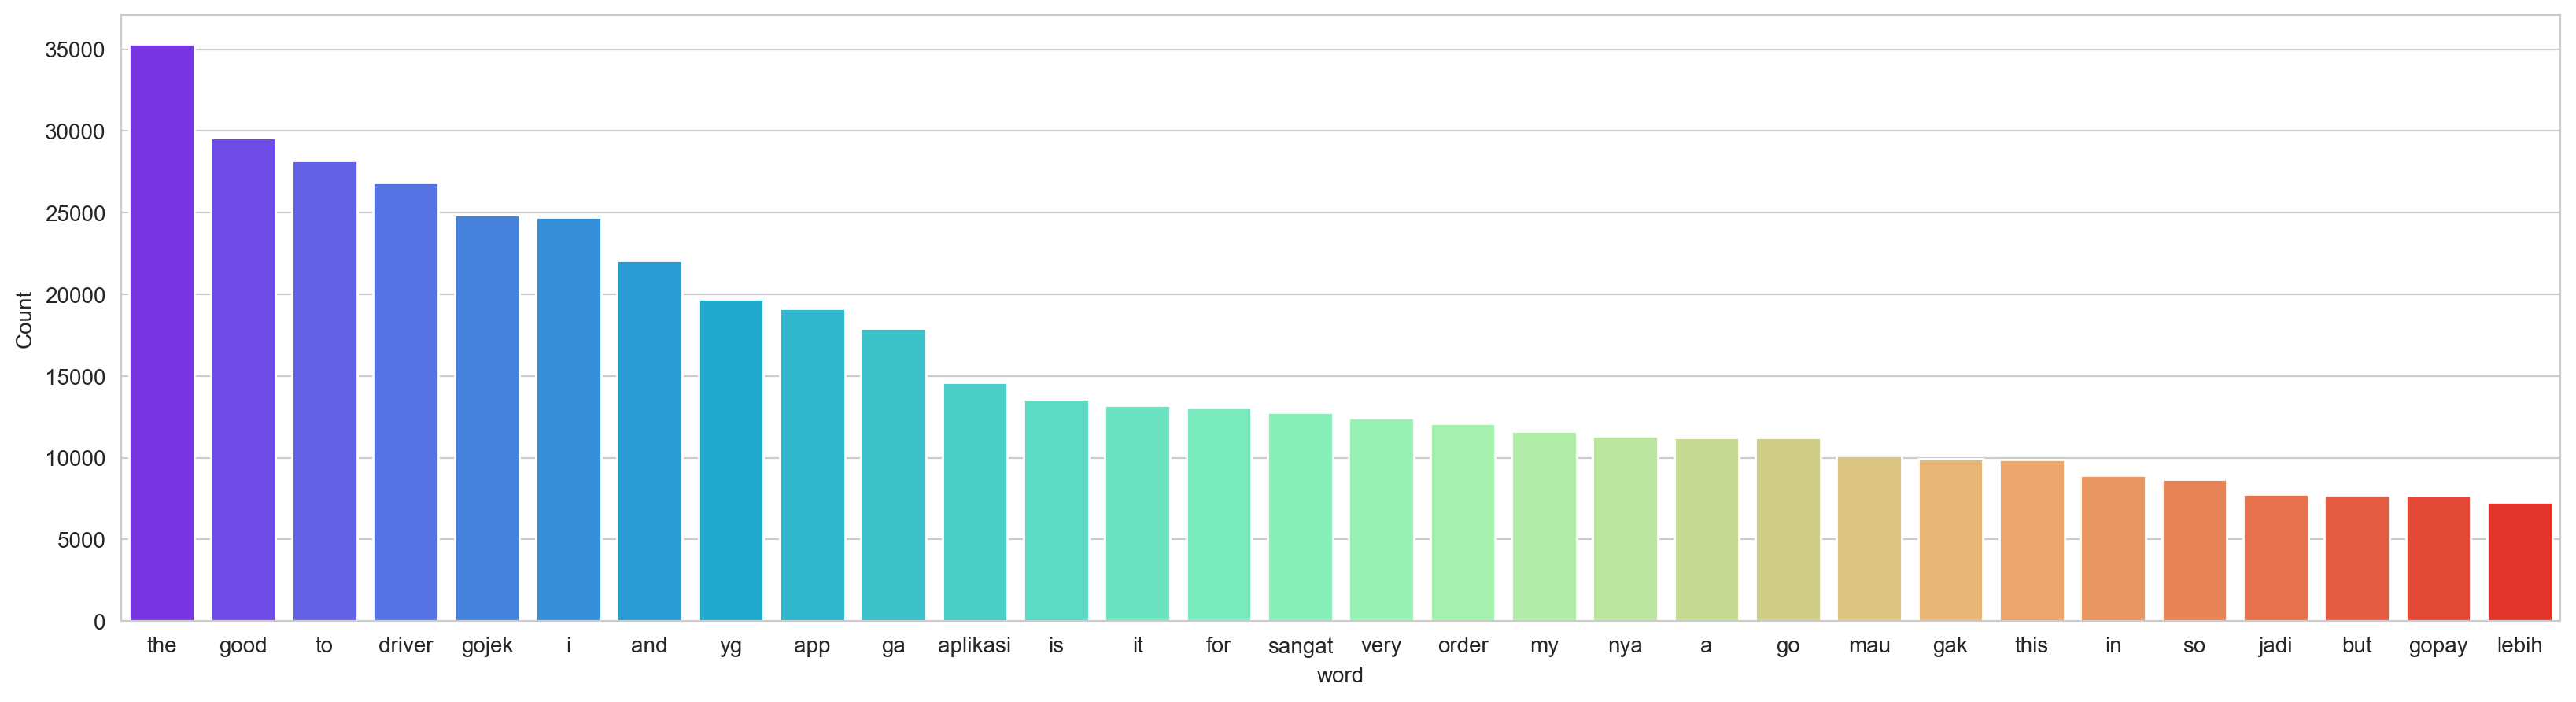

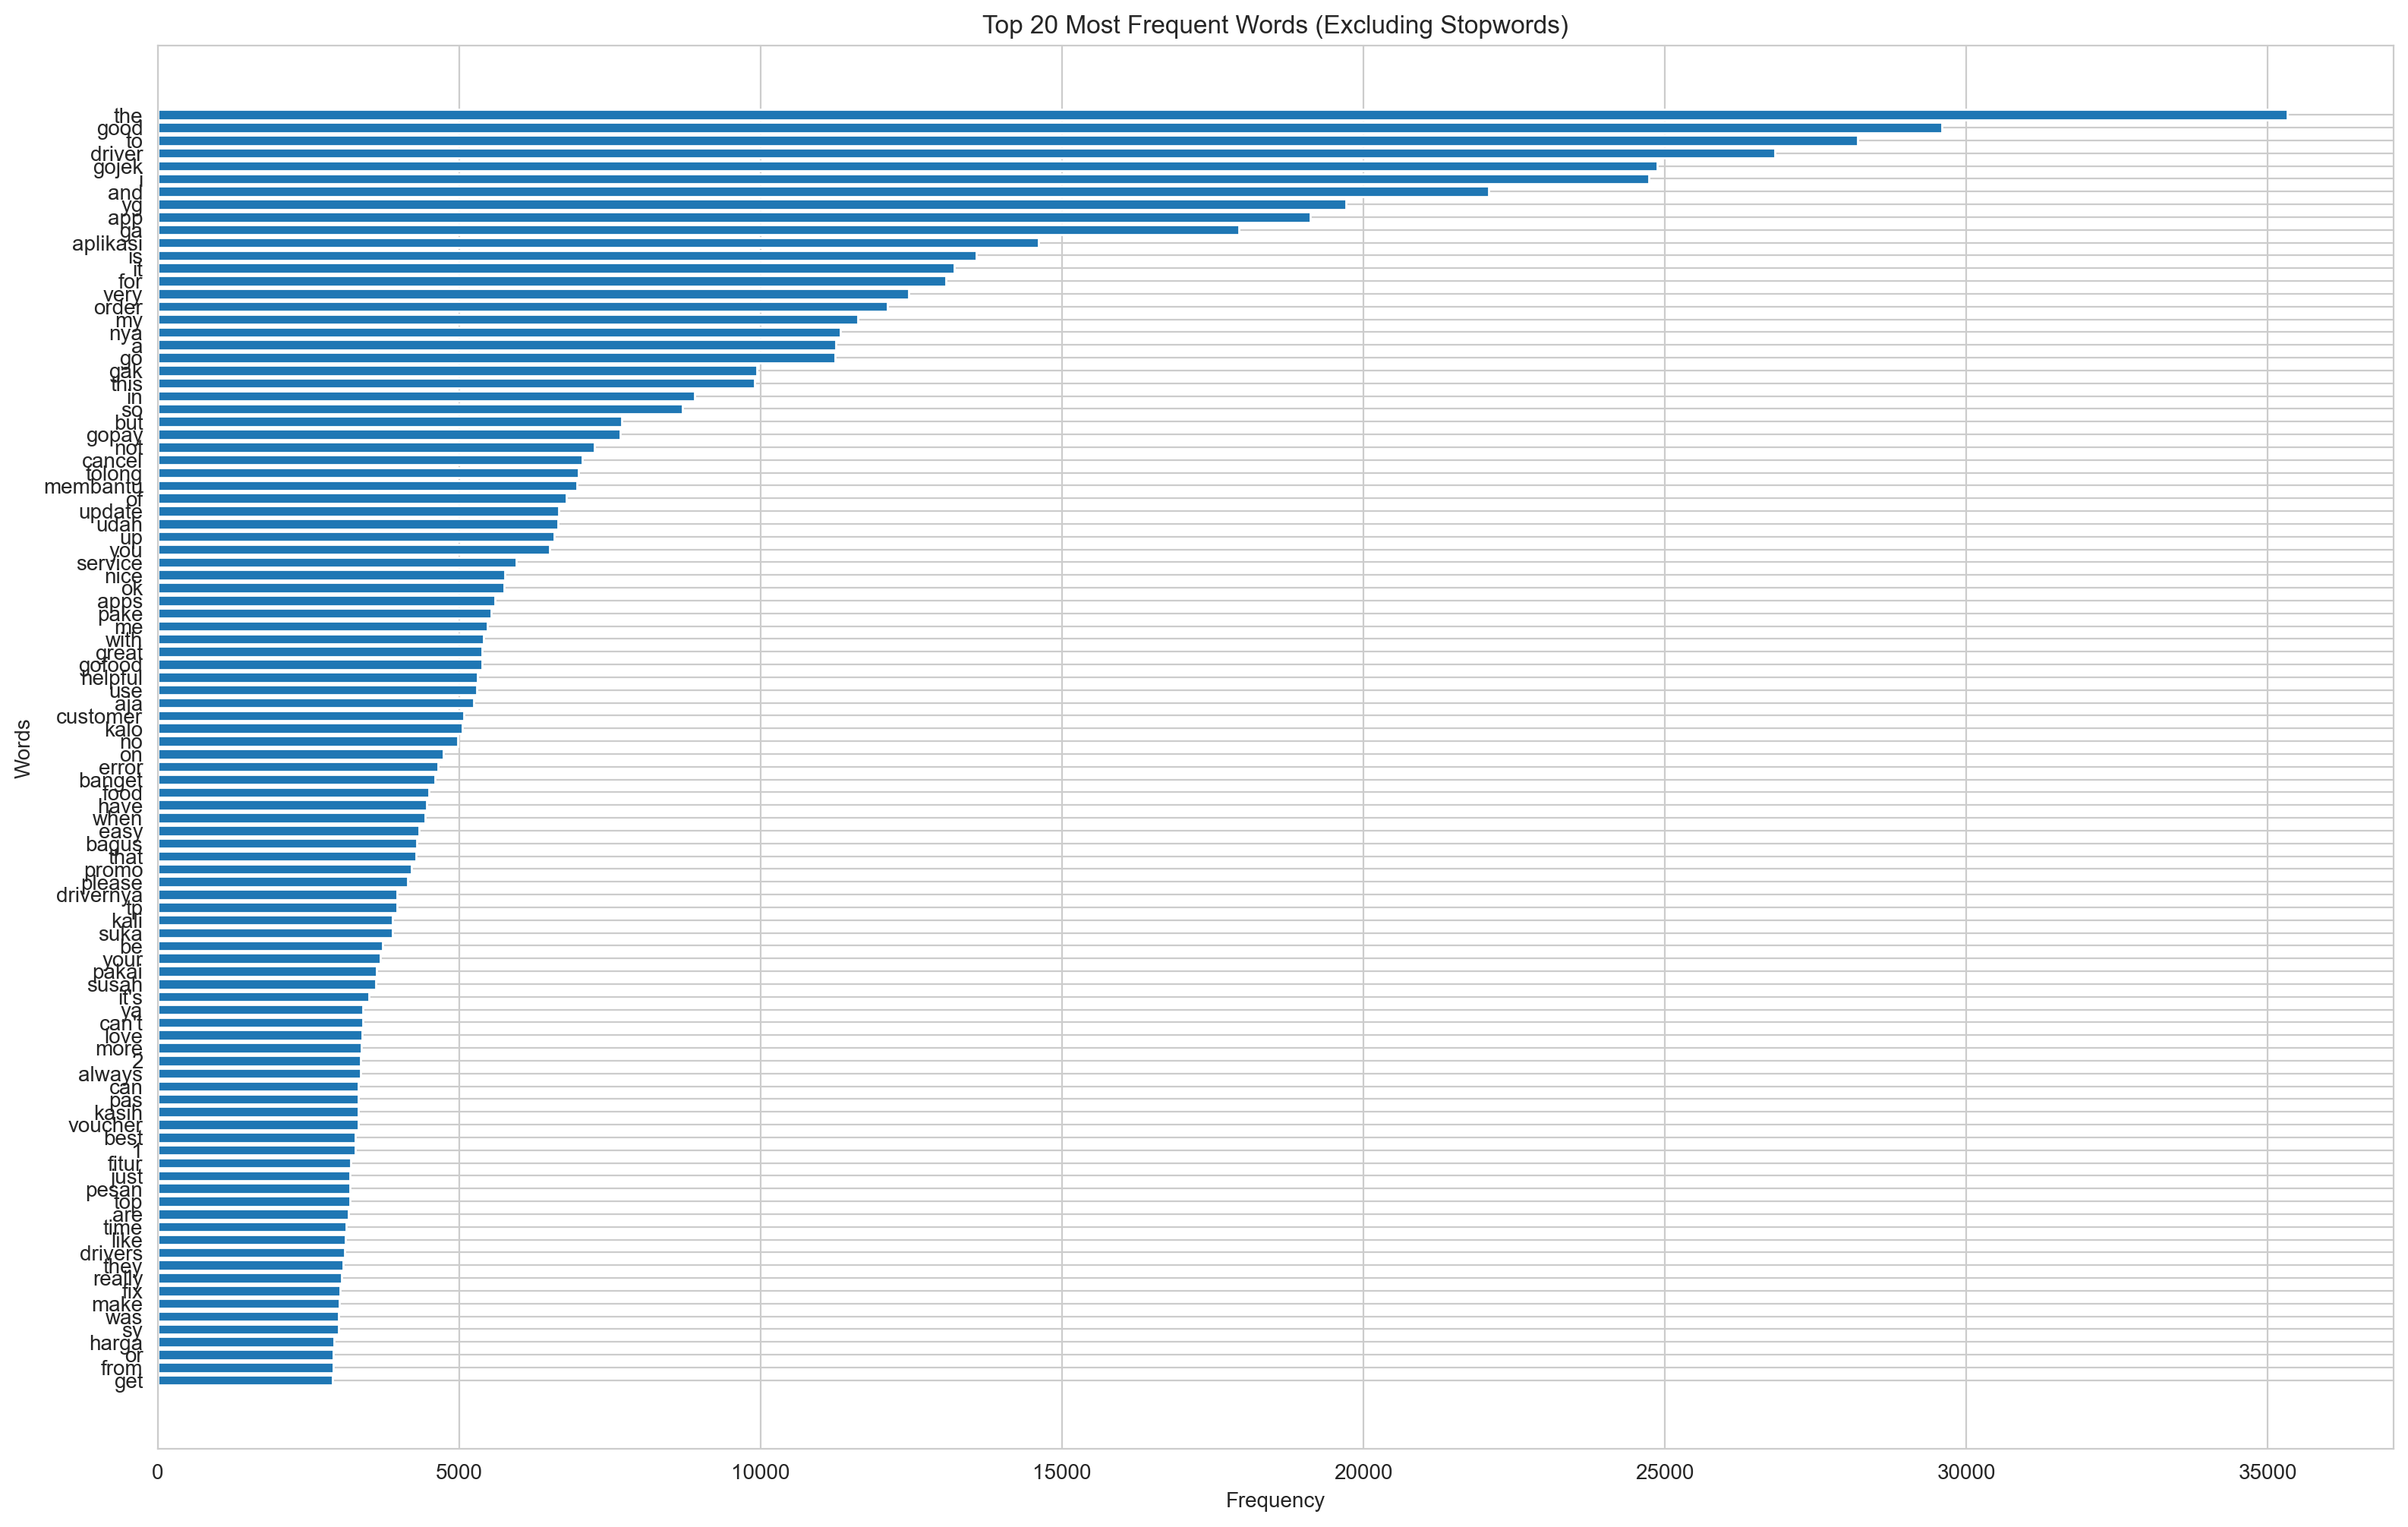

In [31]:
# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

# Plot the frequent words
freq_words(df_gjkrev['content'])
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.show()

## c. Sentiment Analysis after Preprocessing ##

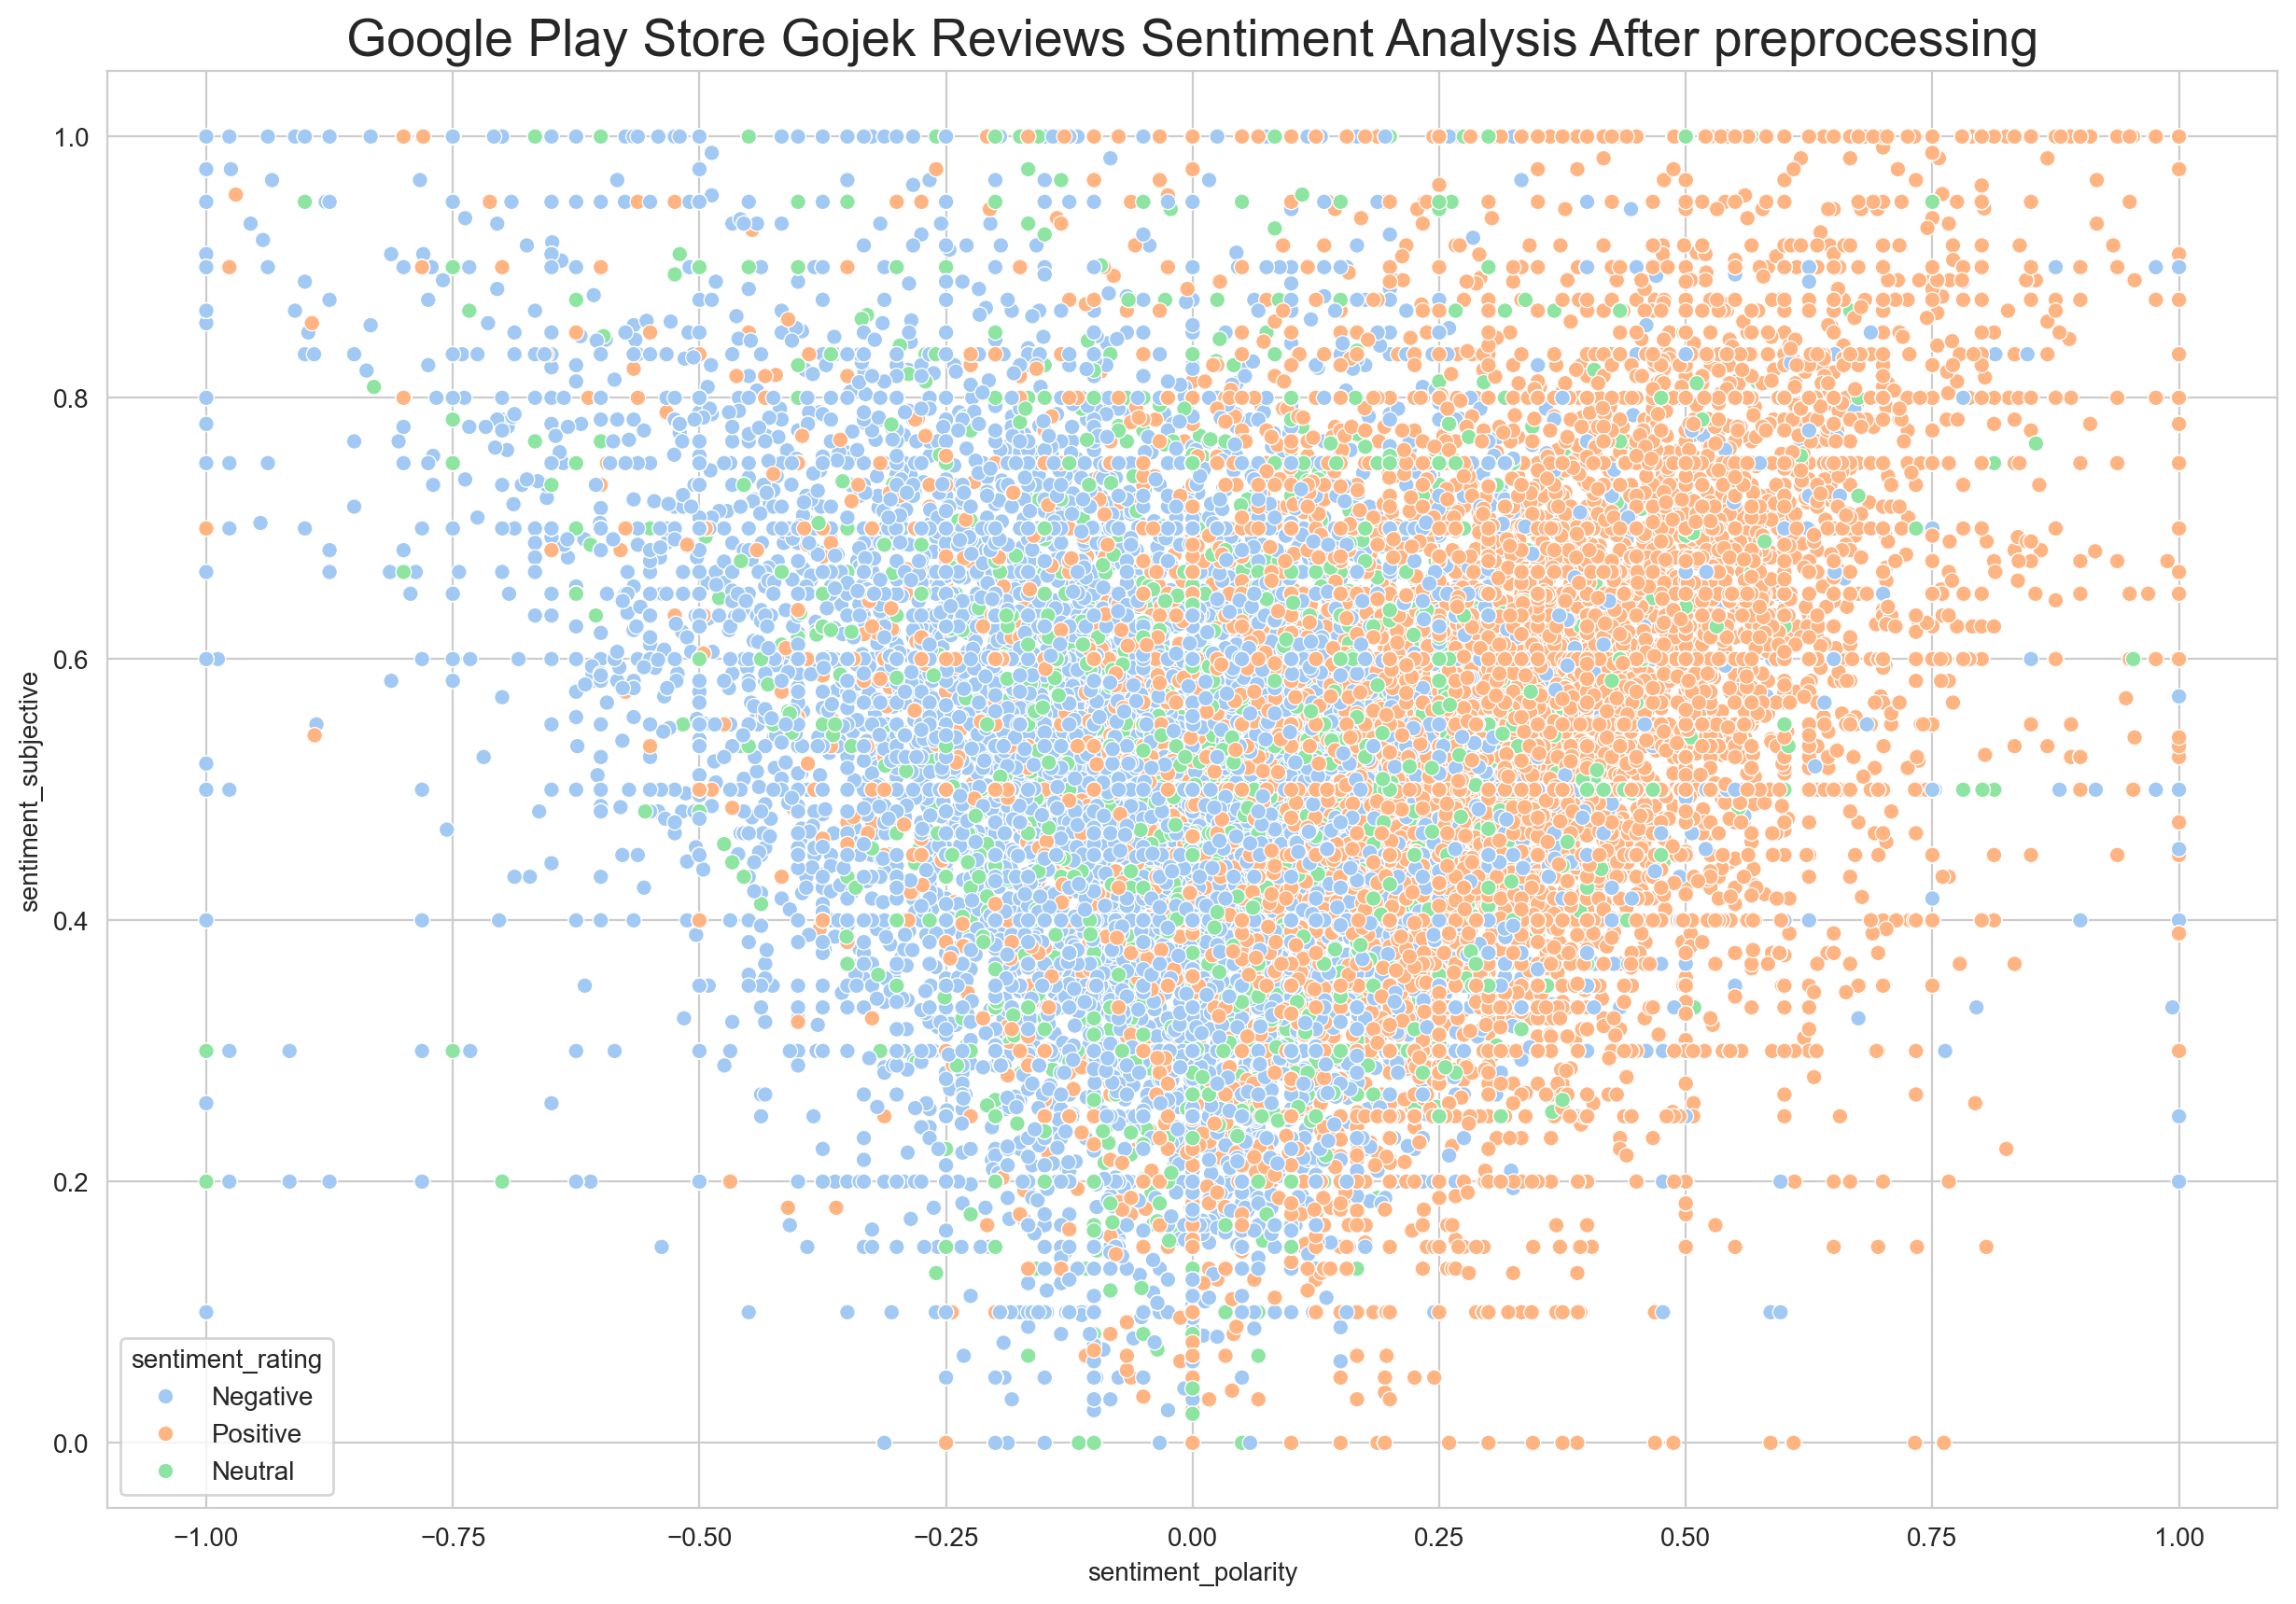

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis After preprocessing", fontsize=20)
plt.show()

In [33]:
# Save the cleaned DataFrame to a new CSV file
df_gjkrev.to_csv(r'data/df_gjkrev_clean.csv', index=False)

# #4 Transformer (TASK 2 START HERE) #

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv("data/df_gjkrev_clean.csv")
print("Dataset shape before:", df.shape)

# Keep only necessary columns
df = df[['content', 'score']].dropna()
print("Dataset shape after:", df.shape)
df.head()


C:\Users\HiliCe\AppData\Local\Temp\ipykernel_15012\1413329488.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/df_gjkrev_clean.csv")


Dataset shape before: (226472, 18)
Dataset shape after: (222253, 2)


content  score
0  vocher bandaranya sering banget udah klaim gak...      1
1                                               good      4
2  susah banget booking ,gak kayak ijo sebelah, m...      2
3  some time good, other times bad. overall so so...      3
4  kodee promonya makin sinii makin menurun, 100 ...      2

## Labeling Sentimen

score > 3 → positive;
score = 3 → neutral;
score < 3 → negative

In [5]:
def convert_label(score):
    if score > 3:
        return 2   # positive
    elif score == 3:
        return 1   # neutral
    else:
        return 0   # negative

df["label"] = df["score"].apply(convert_label)
df.head()

content  score  label
0  vocher bandaranya sering banget udah klaim gak...      1      0
1                                               good      4      2
2  susah banget booking ,gak kayak ijo sebelah, m...      2      0
3  some time good, other times bad. overall so so...      3      1
4  kodee promonya makin sinii makin menurun, 100 ...      2      0

## Preprocessing & Tokenization

Disini Tulisan diubah menjadi angka agar teks bisa diproses transformer

### Build Vocabolary

Kamus kata menjadi angka

In [6]:
def build_vocab(texts, vocab_size=5000):
    word_counts = {}
    for t in texts:
        for w in t.lower().split():
            word_counts[w] = word_counts.get(w, 0) + 1

    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)[:vocab_size]
    vocab = {word: idx+2 for idx, word in enumerate(sorted_vocab)}  # start from 2
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

vocab = build_vocab(df["content"].tolist(), vocab_size=7000)
len(vocab)

7002

### Tokenizer

Memecah teks menjadi token

In [7]:
def simple_tokenizer(text, vocab):
    return [vocab.get(w, vocab["<UNK>"]) for w in text.lower().split()]

## Train/Val/Test Split

Data dibagi untuk latihan dan evaluasi

In [8]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

MAX_LENGTH = 100

## Dataset Class

Disini PyTorch diajarkan bagaimana mengambil data dalam batch

In [9]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = simple_tokenizer(self.texts[idx], self.vocab)
        tokens = tokens[:self.max_length] + [self.vocab["<PAD>"]] * max(0, self.max_length - len(tokens))

        return torch.tensor(tokens), torch.tensor(self.labels[idx])


In [10]:
train_dataset = ReviewDataset(train_df["content"].tolist(), train_df["label"].tolist(), vocab, MAX_LENGTH)
val_dataset   = ReviewDataset(val_df["content"].tolist(),   val_df["label"].tolist(),   vocab, MAX_LENGTH)
test_dataset  = ReviewDataset(test_df["content"].tolist(),  test_df["label"].tolist(),  vocab, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)
test_loader  = DataLoader(test_dataset,  batch_size=32)


## Transformer Model (Just Encoder)

Konten:
- Melakukan Embedding kata (Token -> Vektor)
- Melakukan Positional Encodeng (Dikasih info urutan)
- Melakukan Encoder layer (Self-attention mengolah konteks)
- Linear classifier sebagai output kelas

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1)]
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.fc(x)


In [12]:
embed_dim = 64 # dimensi embedding
num_heads = 2 # jumlah head
hidden_dim = 256
num_layers = 1 # jumlah layer
num_classes = 3  # positive, neutral, negative
vocab_size = len(vocab)

model = TransformerModel(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, MAX_LENGTH).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


## Training and Validation

Training dilakukan loop untuk memodelkan prediksi, menghitung loss, update parameter, cek accuracy, dan simpan hasil setiap epoch

In [13]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

def evaluate(model, loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)

            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()
    return total_loss/len(loader), correct/total

In [14]:
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss/len(train_loader)
    train_acc = correct/total

    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: TL={train_loss:.4f} VL={val_loss:.4f} VA={val_acc:.4f}")


Epoch 1: TL=0.5792 VL=0.5218 VA=0.7987
Epoch 2: TL=0.5082 VL=0.4898 VA=0.8164
Epoch 3: TL=0.4816 VL=0.4696 VA=0.8261
Epoch 4: TL=0.4647 VL=0.4585 VA=0.8307
Epoch 5: TL=0.4527 VL=0.4534 VA=0.8330
Epoch 6: TL=0.4427 VL=0.4450 VA=0.8370
Epoch 7: TL=0.4348 VL=0.4392 VA=0.8389
Epoch 8: TL=0.4283 VL=0.4350 VA=0.8407
Epoch 9: TL=0.4223 VL=0.4311 VA=0.8419
Epoch 10: TL=0.4173 VL=0.4302 VA=0.8429
Epoch 11: TL=0.4129 VL=0.4299 VA=0.8428
Epoch 12: TL=0.4091 VL=0.4240 VA=0.8448
Epoch 13: TL=0.4054 VL=0.4254 VA=0.8447
Epoch 14: TL=0.4024 VL=0.4246 VA=0.8458
Epoch 15: TL=0.3992 VL=0.4234 VA=0.8456


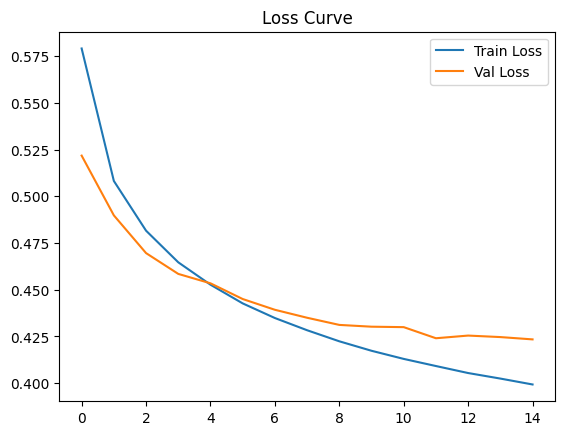

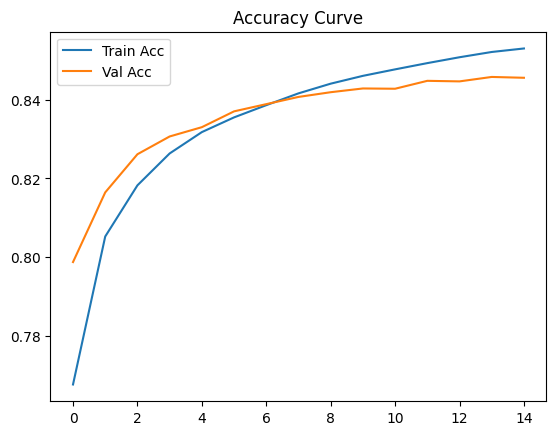

In [15]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

## Test Accuracy

In [16]:
test_loss, test_acc = evaluate(model, test_loader)
print("Test accuracy:", test_acc)

Test accuracy: 0.8445617613534105


## Zero-Shot Baseline

In [17]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

clf = pipeline("zero-shot-classification", 
               model="facebook/bart-large-mnli")

def zero_shot_predict(text):
    result = clf(text, ["positive", "neutral", "negative"])
    return result["labels"][0]

zero_shot_predict("The app is great!")

c:\Users\HiliCe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device set to use cuda:0


'positive'